In [137]:
import re
import nltk
from nltk import wordnet, pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [138]:
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [139]:
import pandas as pd
import numpy as np

In [140]:
from gensim.models.word2vec import Word2Vec

In [141]:
train_df = pd.read_csv('/content/drive/MyDrive/Programming/train.csv', encoding="ISO-8859-1", index_col='Id')

In [142]:
train_df

,Hotel_name,Review_Title,Review_Text,Rating
Id,,,,
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0
...,...,...,...,...
2346,Hyatt Regency Chennai,NaN,Most impressive service by staff in all areas....,80.0
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0


In [143]:
train_df.isna().sum()

Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

Заменим отстутствующие названия отзывов просто на название отеля, ничего плохого не случится, я думаю

In [144]:
train_df.loc[train_df["Review_Title"].isna(), 'Review_Title'] = train_df.loc[train_df["Review_Title"].isna(), 'Hotel_name']

In [145]:
train_df.isna().sum()

Hotel_name      0
Review_Title    0
Review_Text     0
Rating          0
dtype: int64

Соединим заголовок и текст отзыва

In [146]:
train_df['review_full'] = train_df["Review_Title"] + ' ' + train_df['Review_Text']

In [147]:
train_df

,Hotel_name,Review_Title,Review_Text,Rating,review_full
Id,,,,,
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe....
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites. Pricing...
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,"Good stay First of all nice & courteous staff,..."
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...
...,...,...,...,...,...
2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...


Оставим только слова через пробелы

In [148]:
re_new_line = r'\n(\n)+'
re_space_line = r'\n( \n)+'
re_another_symbols = r'[^a-zA-Z ]' 
re_white_spaces = r' +'

def re_sub(pair):
    pair["review_full"] = re.sub(re_another_symbols, '', pair["review_full"])
    pair["review_full"] = re.sub(re_white_spaces, ' ', pair["review_full"])
    pair["review_full"] = re.sub(re_space_line, ' ', pair["review_full"])
    pair["review_full"] = re.sub(re_new_line, ' ', pair["review_full"])
    pair["review_full"] = re.sub(r'\n', ' ', pair["review_full"])
    pair["review_full"] = re.sub(re_white_spaces, ' ', pair["review_full"])
    return pair

df_resub = train_df.apply(re_sub, axis=1)

Токенизируем, лемматизируем...

In [149]:
def get_postag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = [word for word in text.split(" ")]
    stop = stopwords.words('english')
    text = [w for w in text if w not in stop]
    text = [w for w in text if len(w) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(w[0], get_postag(w[1])) for w in pos_tags]
    text = [w for w in text if len(w) > 1]
    text = " ".join(text)
    return(text)


df_resub['clean_text'] = df_resub["review_full"].apply(lambda x: clean_text(x))

In [150]:
df_resub

,Hotel_name,Review_Title,Review_Text,Rating,review_full,clean_text
Id,,,,,,
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...,refuge chennai excellent room exercise facilit...
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe ...,hilton chennai comfortable felt safe staff hel...
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites Pricing ...,worth rating show website price ok worth ratin...
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,Good stay First of all nice courteous staff on...,good stay first nice courteous staff one con s...
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...,need improvement overall ambience hotel good r...
...,...,...,...,...,...,...
2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...,hyatt regency chennai impressive service staff...
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...,homely villa new woodland chennai give homely ...
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...,nice accommodation facility awesome liked neat...


In [151]:
df_resub['Hotel_name'].nunique()

243

In [152]:
from collections import Counter

In [153]:
Counter(df_resub['Hotel_name']).most_common()[:20]

[('The Park Chennai', 70),
 ('The Residency Towers', 61),
 ('Accord Metropolitan', 61),
 ('Radisson Blu GRT Chennai', 60),
 ('Savera', 56),
 ('Park Hyatt', 53),
 ('Raj Park Chennai', 52),
 ('Lemon Tree Chennai', 52),
 ('The Residency Chennai', 47),
 ('E Hotel', 47),
 ('Radisson Chennai City Centre, India', 46),
 ('ITC Grand Chola', 45),
 ('Peace Inn', 43),
 ('FabHotel Priyadarshini Park Mount Road', 38),
 ('The Raintree', 37),
 ('Hilton Chennai', 36),
 ('FabHotel Blossoms T Nagar', 30),
 ("The Raintree, St. Mary's Road", 29),
 ('Taj Club House', 25),
 ('Hyatt Regency Chennai', 22)]

Название отеля можно было бы использовать как категориальный признак, их относительно немного. Но потом их надо как=то к тестовой выборке добавить, учитывая обучающую. Да и на кроссвалидации они добавляют всего 0.5 к RMSE, так что просто удалим потом.

In [154]:
# df_resub['hotel'] = (df_resub['Hotel_name'].astype('category').cat.rename_categories([i for i in range(df_resub['Hotel_name'].nunique())]).astype('int'))

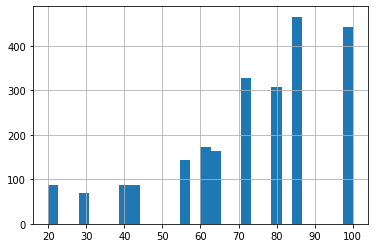

In [155]:
df_resub['Rating'].hist(bins=30)

In [156]:
df_resub['Rating'].nunique()

11

In [157]:
df_resub['Rating'].unique()

array([ 80., 100.,  71.,  86.,  40.,  57.,  43.,  20.,  60.,  65.,  29.])

Странно, конечно... Ну пусть будет задача регрессии

Можно еще добавить длину отзыва

In [158]:
df_resub['review_length'] = df_resub["clean_text"].apply(lambda x: len(x))

In [159]:
df_resub

,Hotel_name,Review_Title,Review_Text,Rating,review_full,clean_text,review_length
Id,,,,,,,
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All arou...,80.0,Refuge in Chennai Excellent room and exercise ...,refuge chennai excellent room exercise facilit...,181
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \r\nStaff were...,100.0,Hilton Chennai Very comfortable and felt safe ...,hilton chennai comfortable felt safe staff hel...,135
2,The Royal Regency,No worth the rating shown in websites. Pricing...,Not worth the rating shown. Service is not goo...,71.0,No worth the rating shown in websites Pricing ...,worth rating show website price ok worth ratin...,220
3,Rivera,Good stay,"First of all nice & courteous staff, only one ...",86.0,Good stay First of all nice courteous staff on...,good stay first nice courteous staff one con s...,159
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In...,86.0,Needs improvement Overall ambience of the hote...,need improvement overall ambience hotel good r...,178
...,...,...,...,...,...,...,...
2346,Hyatt Regency Chennai,Hyatt Regency Chennai,Most impressive service by staff in all areas....,80.0,Hyatt Regency Chennai Most impressive service ...,hyatt regency chennai impressive service staff...,267
2347,New Woodlands,Homely villa,New woodlands chennai which gave me a homely e...,71.0,Homely villa New woodlands chennai which gave ...,homely villa new woodland chennai give homely ...,280
2348,Samudra Residency,Nice accommodation and facilities,Awesome I liked the neatness and maintenance. ...,100.0,Nice accommodation and facilities Awesome I li...,nice accommodation facility awesome liked neat...,178


Теперь можно уже дропнуть исходные столбики

In [160]:
df_drop = df_resub.drop(columns=['Hotel_name', 'Review_Title', 'Review_Text', 'review_full'])

Зачем-то нам дали негативные и положительные слова... Можно как-то использовать. К примеру, посчитать соотношение положительных и негативных слов

In [161]:
with open('/content/drive/MyDrive/Programming/negative-words.txt', 'r', encoding='ISO-8859-1') as f:
    neg_words_list = [w.rstrip('\n') for w in f.readlines()]
with open('/content/drive/MyDrive/Programming/positive-words.txt', 'r', encoding='ISO-8859-1') as f:
    pos_words_list = [w.rstrip('\n') for w in f.readlines()]

In [162]:
neg_words_list[:10], pos_words_list[:10], 

(['2-faced',
  '2-faces',
  'abnormal',
  'abolish',
  'abominable',
  'abominably',
  'abominate',
  'abomination',
  'abort',
  'aborted'],
 ['a+',
  'abound',
  'abounds',
  'abundance',
  'abundant',
  'accessable',
  'accessible',
  'acclaim',
  'acclaimed',
  'acclamation'])

In [163]:
def pos_neg_words(text):
    neg_words = 0
    pos_words = 0
    text_spl = text.split()
    for word in text_spl:
        if word in neg_words_list:
            neg_words += 1
        elif word in pos_words_list:
            pos_words += 1
    if len(text_spl):
        return (pos_words / len(text_spl), neg_words / len(text_spl))
    else:
        return (0.0, 0.0)

In [164]:
pos_neg = df_drop["clean_text"].apply(lambda x: pos_neg_words(x))

In [165]:
neg_list_rate = pos_neg.apply(lambda x: x[0])
pos_list_rate = pos_neg.apply(lambda x: x[1])

In [166]:
df_drop["positive_ratio"], df_drop["negative_ratio"] = pos_list_rate, neg_list_rate

In [167]:
df_drop

,Rating,clean_text,review_length,positive_ratio,negative_ratio
Id,,,,,
0,80.0,refuge chennai excellent room exercise facilit...,181,0.000000,0.160000
1,100.0,hilton chennai comfortable felt safe staff hel...,135,0.000000,0.210526
2,71.0,worth rating show website price ok worth ratin...,220,0.029412,0.264706
3,86.0,good stay first nice courteous staff one con s...,159,0.086957,0.217391
4,86.0,need improvement overall ambience hotel good r...,178,0.000000,0.120000
...,...,...,...,...,...
2346,80.0,hyatt regency chennai impressive service staff...,267,0.000000,0.230769
2347,71.0,homely villa new woodland chennai give homely ...,280,0.000000,0.157895
2348,100.0,nice accommodation facility awesome liked neat...,178,0.000000,0.318182


In [168]:
df_drop.to_csv('/content/drive/MyDrive/Programming/train_df_off.csv')

Попробуем CountVectorizer

In [169]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [170]:
import warnings
warnings.filterwarnings("ignore")

In [171]:
y = df_drop['Rating']
linreg_cv = LinearRegression()
rfr_cv = RandomForestRegressor()
linreg_num = LinearRegression()
rfr_num = RandomForestRegressor()
count_vect = CountVectorizer(ngram_range=(1,2))
tfidf = TfidfVectorizer(ngram_range=(1,2))

In [172]:
X_text_cv = count_vect.fit_transform(df_drop['clean_text'])

In [173]:
X_num = df_drop.drop(columns=['Rating', 'clean_text'])

In [174]:
X_num

,review_length,positive_ratio,negative_ratio
Id,,,
0,181,0.000000,0.160000
1,135,0.000000,0.210526
2,220,0.029412,0.264706
3,159,0.086957,0.217391
4,178,0.000000,0.120000
...,...,...,...
2346,267,0.000000,0.230769
2347,280,0.000000,0.157895
2348,178,0.000000,0.318182


CountVectrizer в линейной регрессии

In [ ]:
-np.mean(cross_val_score(linreg_cv, X_text_cv, y, scoring="neg_root_mean_squared_error", cv=5))

16.655654145019316

Линейная регрессия не на текстовых данных

In [ ]:
-np.mean(cross_val_score(linreg_num, X_num, y, scoring="neg_root_mean_squared_error", cv=5))

18.202353492055966

Можно попробовать сделать ансамбль из текстовой модели и модели по другим признакам 

CountVectrizer в случайном лесе

In [ ]:
-np.mean(cross_val_score(rfr_cv, X_text_cv, y, scoring="neg_root_mean_squared_error", cv=3))

14.922277560034944

Случайный лес не на текстовых данных

In [ ]:
-np.mean(cross_val_score(rfr_num, X_text_cv, y, scoring="neg_root_mean_squared_error", cv=3))

14.93736180206897

Теперь пробуем TF-IDF

In [190]:
X_text_tf = tfidf.fit_transform(df_drop['clean_text'])

In [ ]:
linreg_tf = LinearRegression()
rfr_tf = RandomForestRegressor()

In [ ]:
print(f'RMSE при TF-IDF в линейной регрессии: {-np.mean(cross_val_score(linreg_tf, X_text_tf, y, scoring="neg_root_mean_squared_error", cv=5))}')

RMSE при TF-IDF в линейной регрессии: 13.935547555054551


In [ ]:
print(f'RMSE при TF-IDF в случайном лесе: {-np.mean(cross_val_score(rfr_tf, X_text_tf, y, scoring="neg_root_mean_squared_error", cv=3))}')

RMSE при TF-IDF в случайном лесе: 14.854787043742704


В линейной регрессии ошибка меньше даже...

Ну и Word2Vec еще

In [175]:
from gensim.models.word2vec import Word2Vec

In [176]:
n_features = 100
text_corpus = [x.split(" ") for x in df_drop['clean_text']]
w2v = Word2Vec(text_corpus, min_count=1, sg=1, size=n_features)

In [177]:
X_text_w2v = [np.mean([w2v.wv[w] for w in t.split(" ")], axis=0) for t in df_drop['clean_text']]
X_text_w2v = np.vstack(X_text_w2v)

In [178]:
linreg_w2v = LinearRegression()
rfr_w2v = RandomForestRegressor()

In [179]:
print(f'RMSE при Word2Vec в линейной регрессии: {-np.mean(cross_val_score(linreg_w2v, X_text_w2v, y, scoring="neg_root_mean_squared_error", cv=5))}')

RMSE при Word2Vec в линейной регрессии: 17.272609288670235


In [182]:
print(f'RMSE при Word2Vec в случайном лесе: {-np.mean(cross_val_score(rfr_w2v, X_text_w2v, y, scoring="neg_root_mean_squared_error", cv=3))}')

RMSE при Word2Vec в случайном лесе: 14.928710953631773


Теперь темтовая выборка

In [183]:
test_df = pd.read_csv('/content/drive/MyDrive/Programming/test.csv', encoding="ISO-8859-1", index_col='Id')

In [184]:
test_df

,Hotel_name,Review_Title,Review_Text
Id,,,
2351,ITC Grand Chola,Mr Neeraj,On the night of my arrival from NY I had a min...
2352,Hotel Pandian,NaN,Not so great. But it is still acceptable. Bit...
2353,Oyo Rooms Guindy Olympia Tech Park,Nice stay for corporate people,Been a good place to stay for people who visit...
2354,OYO Apartments Saidapet,Average hotel,Not worth of the money we paid.worst ac.no wat...
2355,Ramada Chennai Egmore,A good mid range corporate hotel,"A well located hotel, with decent sized rooms ..."
...,...,...,...
4698,Lemon Tree Chennai,Average stay,"Compared to other lemon tree stay, this was bi..."
4699,Oyo Rooms T Nagar Off Pondy Bazaar,location is not good. rude behavior. staff no ...,unpleasant stay. not easy task to reach. Morni...
4700,VGP Golden Beach Resort,NaN,Quality of service is too bad. We arrived 12.3...


In [186]:
test_df.isna().sum()

Hotel_name        0
Review_Title    209
Review_Text       0
dtype: int64

In [187]:
test_df.loc[test_df["Review_Title"].isna(), 'Review_Title'] = test_df.loc[test_df["Review_Title"].isna(), 'Hotel_name']
test_df['review_full'] = test_df["Review_Title"] + ' ' + test_df['Review_Text']
df_resub_test = test_df.apply(re_sub, axis=1)
df_resub_test['clean_text'] = df_resub_test["review_full"].apply(lambda x: clean_text(x))
df_resub_test['review_length'] = df_resub_test["clean_text"].apply(lambda x: len(x))
df_drop_test = df_resub_test.drop(columns=['Hotel_name', 'Review_Title', 'Review_Text', 'review_full'])
pos_neg = df_drop_test["clean_text"].apply(lambda x: pos_neg_words(x))
neg_list_rate = pos_neg.apply(lambda x: x[0])
pos_list_rate = pos_neg.apply(lambda x: x[1])
df_drop_test["positive_ratio"], df_drop_test["negative_ratio"] = pos_list_rate, neg_list_rate

Использум лучшую модель (TF-IDF, LinReg)

In [192]:
linreg_tf.fit(X_text_tf, y)

LinearRegression()

In [191]:
X_test_tf = tfidf.transform(df_drop_test['clean_text'])

In [193]:
y_pred = linreg_tf.predict(X_test_tf)
y_pred

array([99.99999988, 82.3426003 , 75.2412842 , ..., 46.65595423,
       40.00000002, 80.00000008])

Поставьте оценку пж...